In [1]:
import json
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit

from constants import RAW_DIR
from src.model import Asteroid

In [2]:
ASTEROID_NAME = "Eros"
ASTEROID_ID = 433
PERIOD = 5.2702553  # in hours
with open(RAW_DIR / ASTEROID_NAME / "lc.json", "r") as f:
    raw_data = json.load(f)

In [3]:
PERIOD / 24

0.21959397083333332

In [4]:
raw_data[0]

{'LightCurve': {'id': '14537',
  'asteroid_id': '1714',
  'scale': '0',
  'filter': None,
  'points': '2433915.385708  1.021246e+00    -1.49250950  -0.20313009  -0.25692782   -0.49091309  -0.15648988  -0.25691486\n2433915.401167  1.018429e+00    -1.49243437  -0.20332590  -0.25693732   -0.49085471  -0.15642099  -0.25692433\n2433915.407583  1.030696e+00    -1.49240319  -0.20340717  -0.25694127   -0.49083050  -0.15639240  -0.25692825\n2433915.423333  1.025016e+00    -1.49232660  -0.20360666  -0.25695094   -0.49077108  -0.15632220  -0.25693789\n2433915.434000  1.008163e+00    -1.49227472  -0.20374176  -0.25695749   -0.49073086  -0.15627466  -0.25694442\n2433915.443625  9.897614e-01    -1.49222789  -0.20386366  -0.25696339   -0.49069459  -0.15623177  -0.25695030\n2433915.453542  9.469576e-01    -1.49217962  -0.20398927  -0.25696948   -0.49065723  -0.15618757  -0.25695637\n2433915.458333  9.211503e-01    -1.49215630  -0.20404995  -0.25697241   -0.49063919  -0.15616622  -0.25695929\n2433915.4

In [5]:
asteroid = Asteroid.from_lightcurves(
    id=ASTEROID_ID,  # Where to get this id from?
    name=ASTEROID_NAME,
    period=PERIOD,
    data=raw_data
)
asteroid

Asteroid(id=433, name=Eros, period=5.2702553, lightcurves=118)

In [6]:
lcs = [lc for lc in asteroid.lightcurves]
longest_lc = max(lcs, key=lambda lc: lc.points_count)
longest_lc

LightCurve(id=14587, scale=0, points=[Point(JD=2442416.291643, brightness=0.7874685, x_sun=0.28672635, y_sun=-1.1053174, z_sun=-0.07477441, x_earth=0.06333529, y_earth=-0.14772884, z_earth=-0.07470525), Point(JD=2442416.292018, brightness=0.7527195, x_sun=0.2867326, y_sun=-1.10531546, z_sun=-0.07477322, x_earth=0.06333515, y_earth=-0.14772838, z_earth=-0.07470405), Point(JD=2442416.292726, brightness=0.7031261, x_sun=0.28674438, y_sun=-1.10531179, z_sun=-0.07477096, x_earth=0.06333487, y_earth=-0.14772753, z_earth=-0.0747018), Point(JD=2442416.293851, brightness=0.667165, x_sun=0.28676311, y_sun=-1.10530595, z_sun=-0.07476738, x_earth=0.06333444, y_earth=-0.14772616, z_earth=-0.07469821), Point(JD=2442416.294601, brightness=0.5984574, x_sun=0.2867756, y_sun=-1.10530206, z_sun=-0.07476499, x_earth=0.06333415, y_earth=-0.14772525, z_earth=-0.07469582), Point(JD=2442416.296434, brightness=0.5610908, x_sun=0.28680612, y_sun=-1.10529255, z_sun=-0.07475915, x_earth=0.06333344, y_earth=-0.147

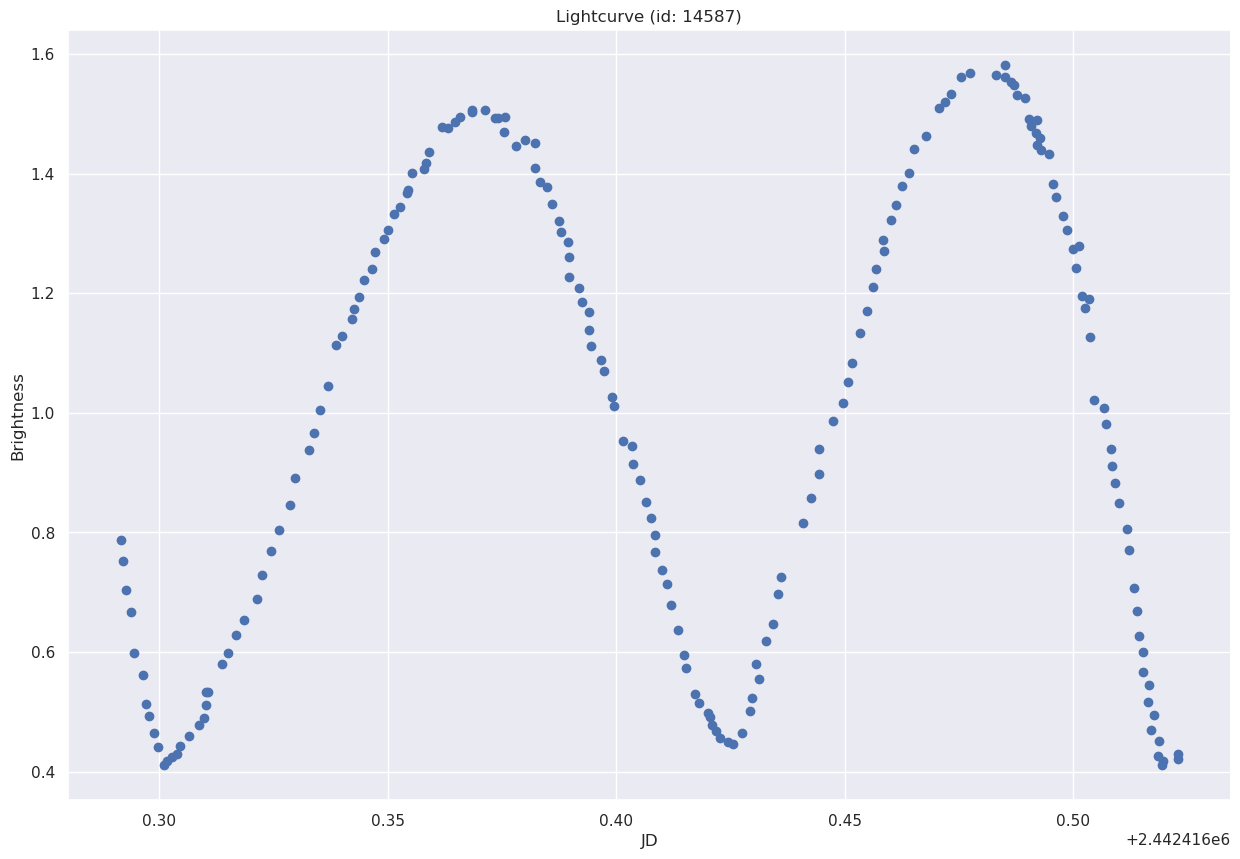

In [18]:
longest_lc.plot()

In [8]:
lc, = [lc for lc in asteroid.lightcurves if lc.id == 14654]
lc

LightCurve(id=14654, scale=0, points=[Point(JD=2449252.213016, brightness=1.348828, x_sun=-1.43434666, y_sun=0.98481174, z_sun=-0.11966228, x_earth=-0.43078747, y_earth=0.96400551, z_earth=-0.1196627), Point(JD=2449252.216691, brightness=1.242672, x_sun=-1.4343662, y_sun=0.98477419, z_sun=-0.11966942, x_earth=-0.43080672, y_earth=0.96403094, z_earth=-0.11966985), Point(JD=2449252.218775, brightness=1.297647, x_sun=-1.43437727, y_sun=0.98475289, z_sun=-0.11967348, x_earth=-0.43081764, y_earth=0.96404536, z_earth=-0.1196739), Point(JD=2449252.221725, brightness=1.208806, x_sun=-1.43439295, y_sun=0.98472275, z_sun=-0.11967921, x_earth=-0.4308331, y_earth=0.96406577, z_earth=-0.11967963), Point(JD=2449252.223208, brightness=1.188931, x_sun=-1.43440083, y_sun=0.98470759, z_sun=-0.1196821, x_earth=-0.43084087, y_earth=0.96407603, z_earth=-0.11968251), Point(JD=2449252.226366, brightness=1.115723, x_sun=-1.43441761, y_sun=0.98467532, z_sun=-0.11968823, x_earth=-0.43085742, y_earth=0.96409788,

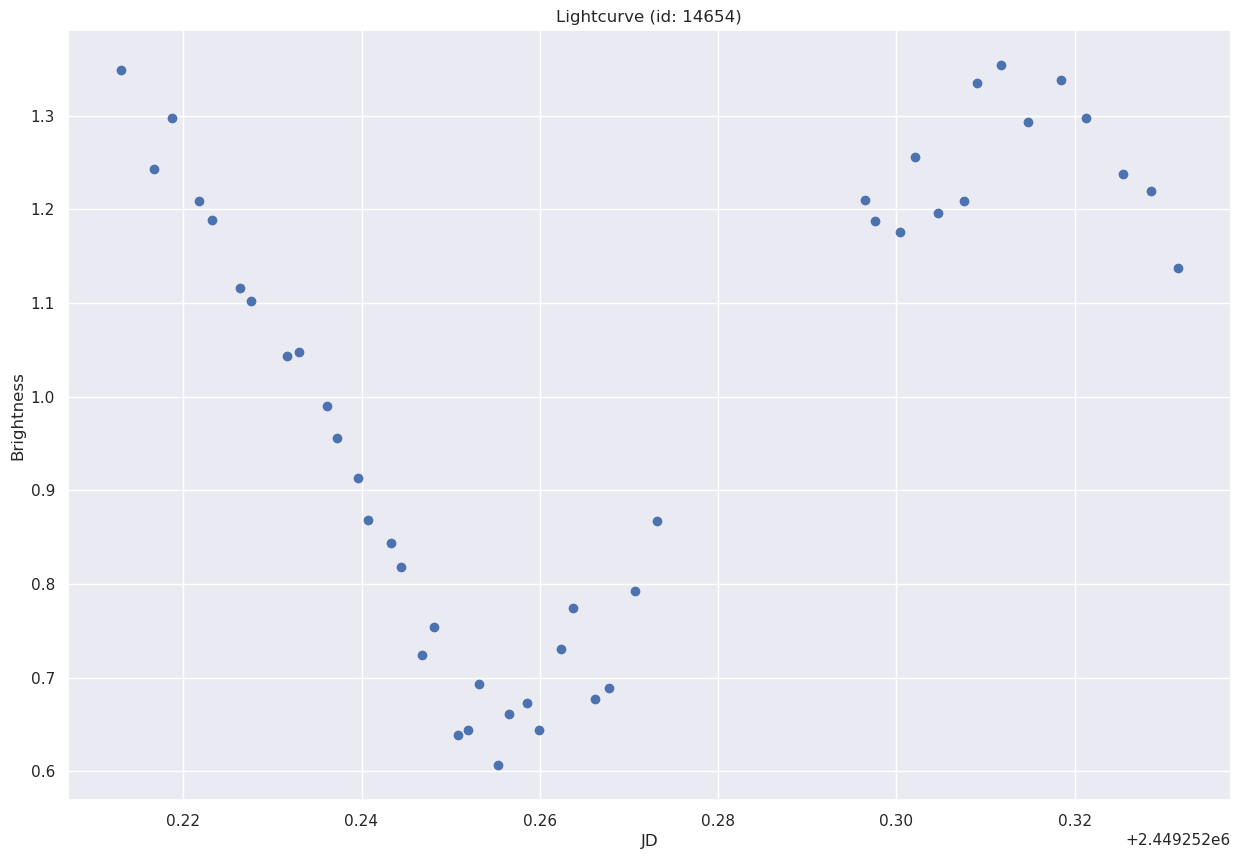

In [9]:
lc.plot()

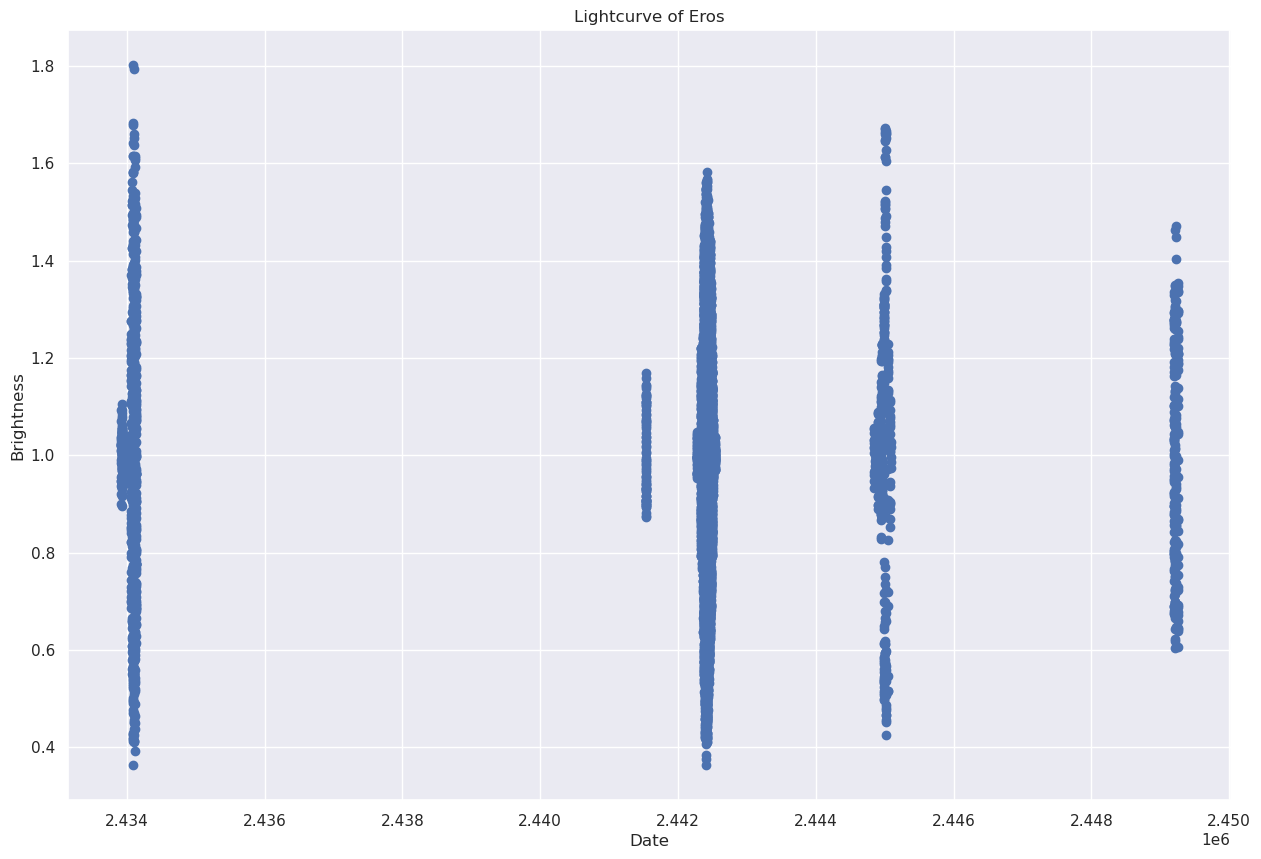

In [17]:
asteroid.plot_lc_by_dates()

Best period: 1.0054178727309566


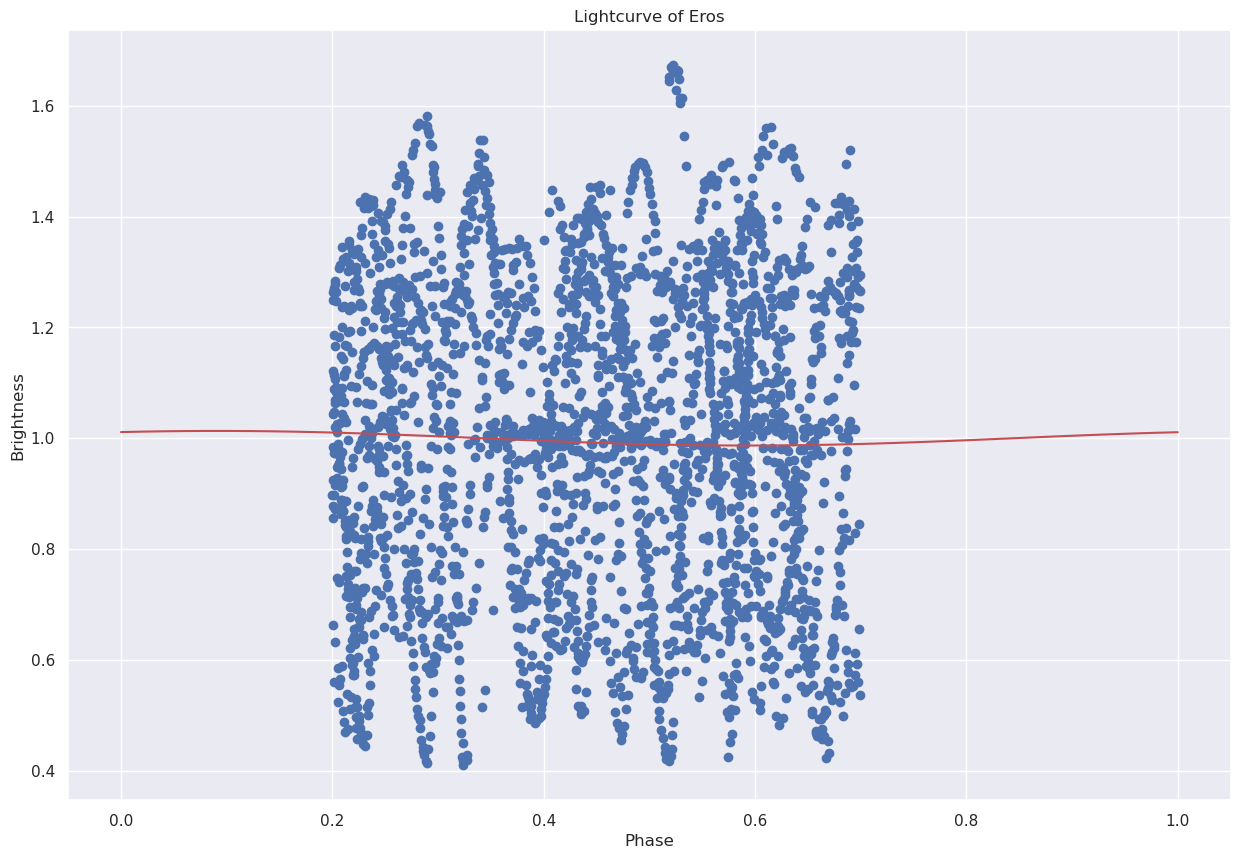

In [12]:
phases, brightnesses = asteroid.plot_lightcurves()

In [15]:
step = 0.01
end = 1 + step
bin_edges = np.arange(0, end, step)
bin_edges

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [16]:
bins = np.digitize(phases, bin_edges)
bins

array([86, 86, 86, ..., 62, 62, 62])

In [17]:
phase_bins = {}
brightness_bins = {}

for b, (phase, bright) in zip(bins, zip(phases, brightnesses)):
    if b in brightness_bins:
        brightness_bins[b].append(bright)
        phase_bins[b].append(phase)
    else:
        brightness_bins[b] = [bright]
        phase_bins[b] = [phase]

In [18]:
mean_phases = []
mean_brightnesses = []

for b in sorted(brightness_bins.keys()):
    mean_phases.append(np.mean(phase_bins[b]))
    mean_brightnesses.append(np.mean(brightness_bins[b]))

In [19]:
len(phases), len(brightnesses)

(2926, 2926)

In [20]:
len(mean_phases), len(mean_brightnesses)


(100, 100)

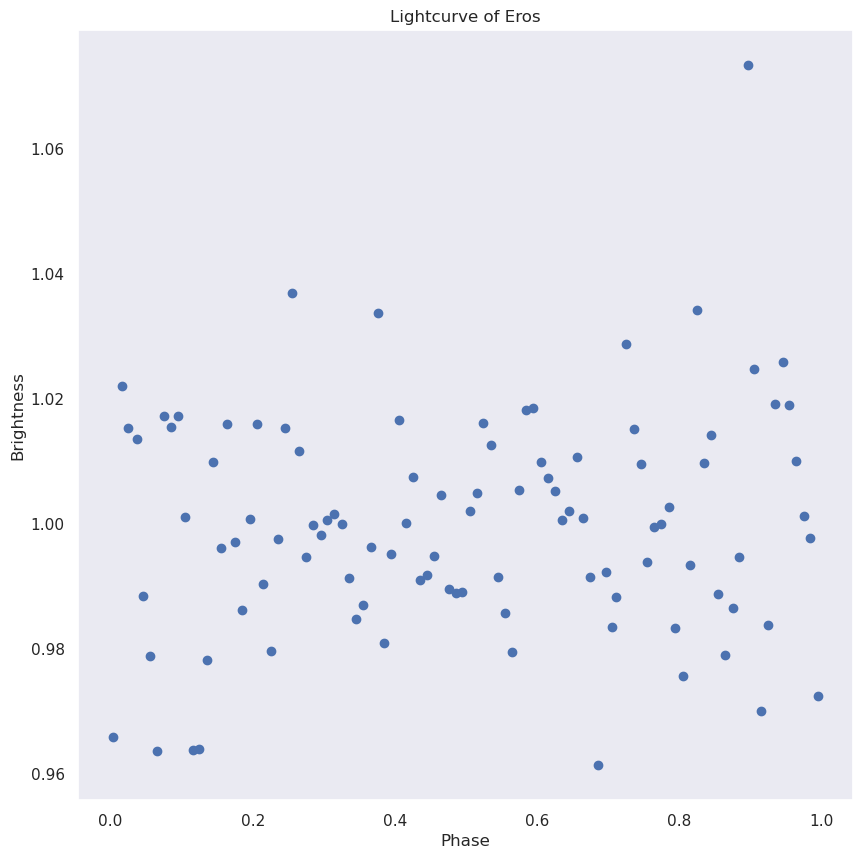

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mean_phases, mean_brightnesses)
ax.set_xlabel("Phase")
ax.set_ylabel("Brightness")
ax.set_title("Lightcurve of Eros")
ax.grid()
plt.show()


In [37]:
def fourier_series(x, *a):
    reconstruction = a[0]
    an = a[1::2]
    bn = a[2::2]
    for i in range(len(an)):
        freq = 2 * np.pi * (i + 1)
        reconstruction += an[i] * np.cos(freq * x) + bn[i] * np.sin(freq * x)

    return reconstruction


N = 36
params = [0.1] * 2 * N
initial_guess = [np.mean(brightnesses), *params]

In [38]:
phases = np.array(phases)
brightnesses = np.array(brightnesses)

In [39]:
# sort the phases and brightnesses by phase
idx = np.argsort(phases)
phases = phases[idx]
brightnesses = brightnesses[idx]

In [40]:
popt, pcov = curve_fit(f=fourier_series, xdata=phases, ydata=brightnesses, p0=initial_guess)

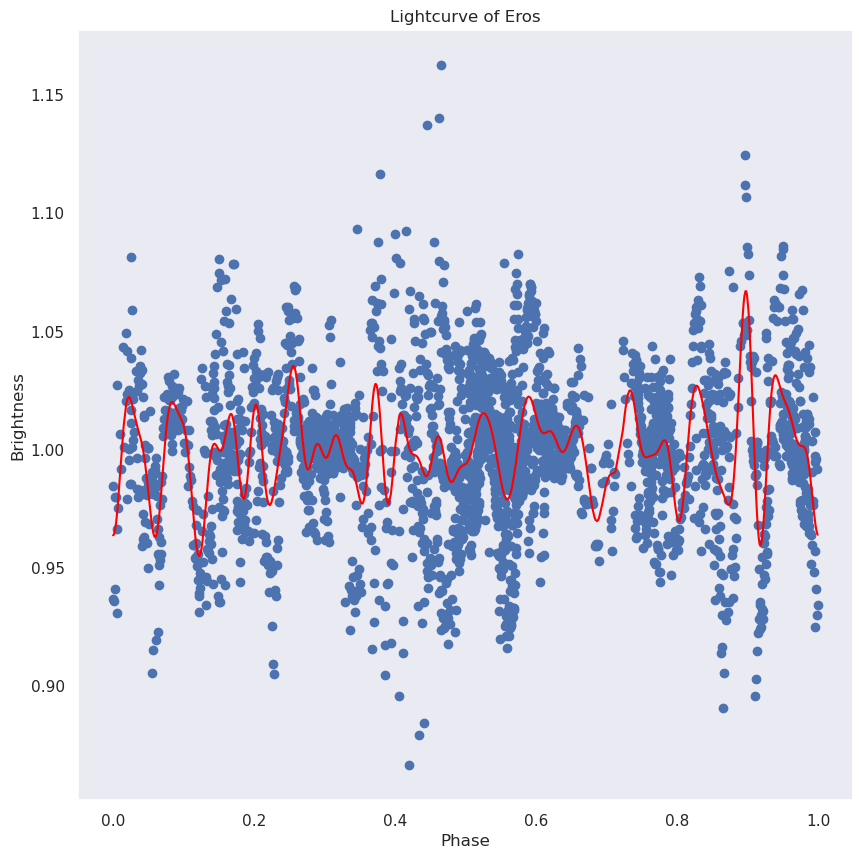

In [41]:
fitted_curve = fourier_series(np.array(phases), *popt)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(phases, brightnesses)
ax.plot(phases, fitted_curve, color="red")
ax.set_xlabel("Phase")
ax.set_ylabel("Brightness")
ax.set_title("Lightcurve of Eros")
ax.grid()

plt.show()